In [14]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt, seaborn as sns
import folium 
from sklearn.metrics.pairwise import (cosine_similarity, euclidean_distances, manhattan_distances) 
from IPython.display import display
from surprise import SVD, Dataset, NormalPredictor, Reader, accuracy, KNNBasic, evaluate
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV, KFold
from collections import defaultdict


%matplotlib inline

# EDA 

### Read Business Dataset

In [15]:
business = pd.read_csv('../yelp_academic_dataset/yelp_business.csv')

In [16]:
business.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...


### Dataset Includes ~175,000 Businesses

In [17]:
business.shape

(174567, 13)

### The Dataset includes 68 'State' values, I decided to look at only 'States' with more than 200 businesses

In [18]:
states = business['state'].value_counts()[business['state'].value_counts() > 200]

In [19]:
states = pd.DataFrame({'state':states.index, 'count':states.values})

In [20]:
states

,count,state
0,52214,AZ
1,33086,NV
2,30208,ON
3,12956,NC
4,12609,OH
5,10109,PA
6,8169,QC
7,4754,WI
8,3795,EDH
9,3118,BW


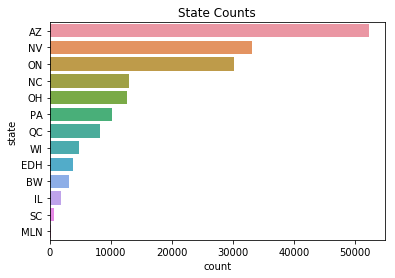

In [21]:
sns.barplot(x='count', y='state', data=states)
plt.title("State Counts");

### The Dataset includes ~1000 'City' values, I decided to look at only cities with more than 1000 businesses

In [22]:
cities = business['city'].value_counts()[business['city'].value_counts() > 1000]

In [23]:
cities = pd.DataFrame({'city':cities.index, 'count':cities.values})
cities

,city,count
0,Las Vegas,26775
1,Phoenix,17213
2,Toronto,17206
3,Charlotte,8553
4,Scottsdale,8228
5,Pittsburgh,6355
6,Mesa,5760
7,Montréal,5709
8,Henderson,4465
9,Tempe,4263


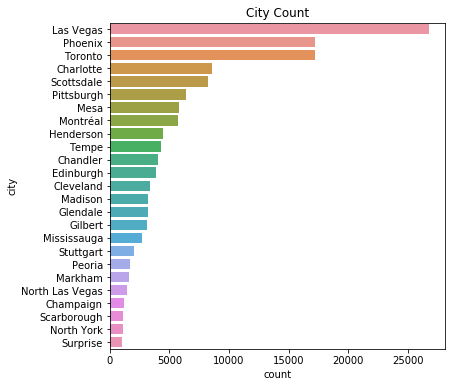

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='count', y='city', data=cities, ax=ax)
plt.title("City Count");

### Mask Business Dataset to Test Workability
#### First Use 'Las Vegas' (Largest Market) &  > 1000 reviews  (to improve matches between users)

In [25]:
business = business[(business['city'] == 'Las Vegas') & (business['review_count'] > 1000)]

In [26]:
business.shape

(186, 13)

In [27]:
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
800,o7AiTlyWUrBSzdz6oMHj5w,"""Excalibur Hotel""",The Strip,"""Excalibur Hotel And Casino, 3850 Las Vegas Bl...",Las Vegas,NV,89109,36.098732,-115.174726,2.5,2504,1,Hotels;Event Planning & Services;Casinos;Resor...
801,PgJgpW4TKQ8IoALH2Yq-zA,"""Bayside Buffet at Mandalay Bay""",The Strip,"""3950 S Las Vegas Blvd""",Las Vegas,NV,89109,36.091219,-115.175804,3.0,1033,1,Arts & Entertainment;Restaurants;Buffets;Ameri...
2803,5iSmZO0SrKU6EoXK_1M8Kw,"""Monte Carlo Hotel And Casino""",The Strip,"""3770 Las Vegas Blvd S""",Las Vegas,NV,89109,36.104614,-115.176021,2.5,2507,1,Resorts;Hotels & Travel;Event Planning & Servi...
4416,OVTZNSkSfbl3gVB9XQIJfw,"""Cravings Buffet""",The Strip,"""3400 Las Vegas Blvd S""",Las Vegas,NV,89109,36.121237,-115.174105,3.0,1252,1,American (Traditional);Buffets;Restaurants;Ame...
4439,JDZ6_yycNQFTpUZzLIKHUg,"""El Dorado Cantina""",NaN,"""3025 Sammy Davis Jr Dr""",Las Vegas,NV,89109,36.134915,-115.175822,4.0,1694,1,Lounges;Mexican;Restaurants;Bars;Nightlife


### Truncate Business Columns

In [28]:
business_trunc = business[['business_id', 'name', 'city', 'state', 'review_count']]

In [29]:
business_trunc.head(5)

,business_id,name,city,state,review_count
800,o7AiTlyWUrBSzdz6oMHj5w,"""Excalibur Hotel""",Las Vegas,NV,2504
801,PgJgpW4TKQ8IoALH2Yq-zA,"""Bayside Buffet at Mandalay Bay""",Las Vegas,NV,1033
2803,5iSmZO0SrKU6EoXK_1M8Kw,"""Monte Carlo Hotel And Casino""",Las Vegas,NV,2507
4416,OVTZNSkSfbl3gVB9XQIJfw,"""Cravings Buffet""",Las Vegas,NV,1252
4439,JDZ6_yycNQFTpUZzLIKHUg,"""El Dorado Cantina""",Las Vegas,NV,1694


### Read User Dataset

In [30]:
user = pd.read_csv('../yelp_academic_dataset/yelp_user.csv')

In [31]:
user.head(2)

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


### Dataset Includes ~1.3 million users

In [32]:
user.shape

(1326100, 22)

### User Review Count is heavily skewed left, this makes logical since most users are known to write reviews infrequently

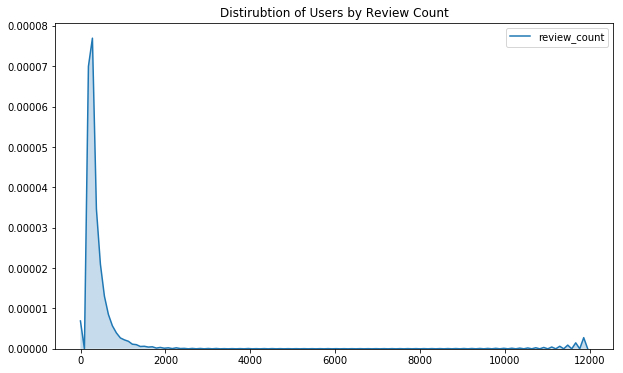

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(user['review_count'], shade=True, ax=ax)
plt.title('Distirubtion of Users by Review Count');

### Individual Review scarcity is one of the inherehnt challenges for collaborative filtering with this dataset

In [34]:
pd.DataFrame(user['review_count'].describe())

,review_count
count,1.326100e+06
mean,2.311717e+01
std,7.909808e+01
min,0.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.500000e+01
max,1.195400e+04


### Mask User Dataset to Test Workability
#### First Power Users w/ ' > 500' Reviews (to improve matches between businesses)

In [35]:
user = user[user['review_count'] > 500]

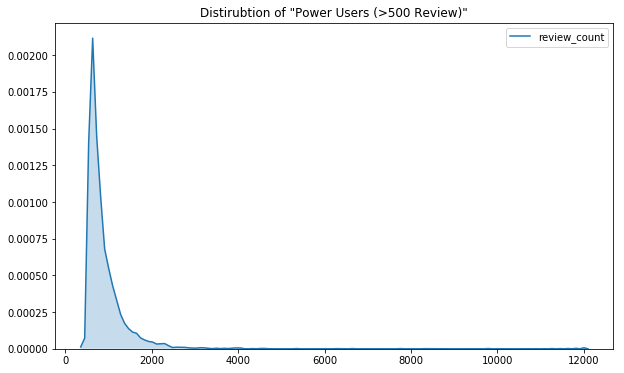

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(user['review_count'], shade=True, ax=ax)
plt.title('Distirubtion of "Power Users (>500 Review)"');

In [37]:
user['user_id'].value_counts().sum()

5903

### Truncate User Columns

In [38]:
user_trunc = user[['user_id', 'review_count']]

In [39]:
user_trunc.head()

,user_id,review_count
74,aw973Pm1nrTbRjP4zY9B9g,762
212,wm97KC6G0resSDXTmNIMKw,1262
730,oH9K7eCuNsYr6MmlM2ZjUg,902
756,bzMzZE3OCqHhZyXH5JRaWw,851
794,lmJy4OwP_TyHIg8a8Q0RsA,646


In [40]:
user_trunc.shape

(5903, 2)

### Read Review Dataset
#### This Dataset includes ~ 4.5 million reviews, to increase speed I am limiting number of rows at import

In [179]:
reviews = pd.read_csv('../yelp_academic_dataset/yelp_review.csv') #nrows=500000)

In [188]:
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [189]:
reviews.shape

(5261668, 9)

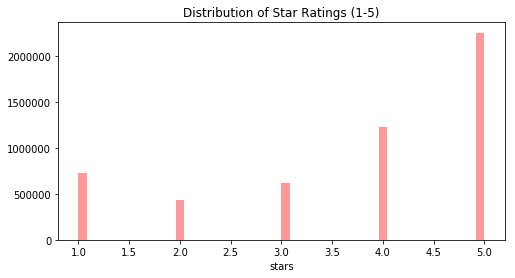

In [190]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(reviews['stars'], kde=False, color='red', ax=ax)
plt.title("Distribution of Star Ratings (1-5)");

In [191]:
pd.DataFrame(reviews['stars'].describe())

,stars
count,5.261668e+06
mean,3.727739e+00
std,1.433593e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Truncate Review Columns

In [192]:
reviews_trunc = reviews[['review_id', 'user_id', 'business_id','stars']]

In [193]:
reviews_trunc.head(10)

,review_id,user_id,business_id,stars
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4
5,HRPm3vEZ_F-33TYVT7Pebw,_4iMDXbXZ1p1ONG297YEAQ,8QWPlVQ6D-OExqXoaD2Z1g,5
6,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg,9_CGhHMz8698M9-PkVf0CQ,4
7,8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4
8,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3
9,WF_QTN3p-thD74hqpp2j-Q,u0LXt3Uea_GidxRW1xcsfg,fDF_o2JPU8BR1Gya--jRIA,5


### Merge Datasets so that Masks create a limited a single DataFrame

In [223]:
df = reviews_trunc.merge(user_trunc, how='inner', on='user_id').merge(business_trunc, how='inner', on='business_id')

In [224]:
df.shape

(31908, 9)

### Drop Columns not needed for Model

In [225]:
df.drop(['review_id','review_count_x', 'name', 'city', 'state', 'review_count_y'], axis=1, inplace=True)

In [226]:
df.head()

,user_id,business_id,stars
0,tL2pS5UOmN6aAOi3Z-qFGg,eAc9Vd6loOgRQolMXQt6FA,4
1,3wB-JjsUjkvdNUDRnChsVg,eAc9Vd6loOgRQolMXQt6FA,4
2,3EAHMMsNnN4rrQVPPuzdnw,eAc9Vd6loOgRQolMXQt6FA,3
3,m8nDqQ7a3zQWfkNK1_vwnQ,eAc9Vd6loOgRQolMXQt6FA,4
4,-hxUwfo3cMnLTv-CAaP69A,eAc9Vd6loOgRQolMXQt6FA,4


In [227]:
df.shape

(31908, 3)

#### Set Minimum # of User Reviews to Be Included

In [228]:
df = df.groupby('user_id').filter(lambda group: len(group) > 10)

#### Set Minimum # of Business Reviews to Be Included

In [229]:
df = df.groupby('business_id').filter(lambda group: len(group) > 20)

### DataFrame Descrptition  

In [230]:
print("\n")
print("Number of reviews included: %s " %df.shape[0])
print("")
print("Number of unique users included: %s" %df['user_id'].unique().size)
print("")
print("Number of unique businesses included: %s" %df['business_id'].unique().size)
print("\n")



Number of reviews included: 18764 

Number of unique users included: 928

Number of unique businesses included: 182




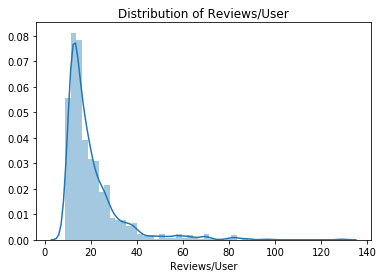

In [231]:
sns.distplot(df['user_id'].value_counts(), axlabel='Reviews/User')
plt.title("Distribution of Reviews/User");

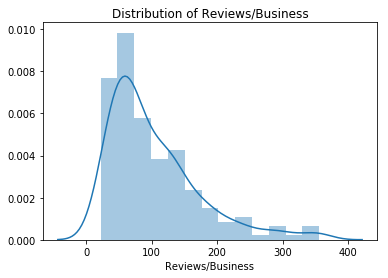

In [232]:
sns.distplot(df['business_id'].value_counts(), axlabel='Reviews/Business')
plt.title("Distribution of Reviews/Business");

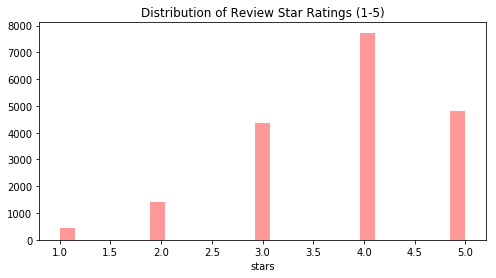

In [233]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(df['stars'], kde=False, color='red', ax=ax)
plt.title("Distribution of Review Star Ratings (1-5)");

In [234]:
pd.DataFrame(df['stars'].describe())

,stars
count,18764.000000
mean,3.805052
std,0.977792
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


## Create/Test Models Using Surprise Package

In [235]:

# Create Reader w/ Scale to Import DataFrame into Surprise
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['user_id', 'business_id', 'stars']], reader)

# Define Algorithm for Model

# algo = sim_options = {'name': 'cosine',
#                 'user_based': True  # compute  similarities between items
#                 }
# algo = KNNBasic(sim_options=sim_options)

algo = SVD()

# Use Train_Test_Split on data
trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE & MAE
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 0.8811
0.8811015744924648
MAE:  0.6943
0.6943135254660338


## Create Function to Rank Top Predictions(Recommended Businesses) / User

In [236]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = sim_options = {'name': 'cosine',
                'user_based': False  # compute  similarities between items 
                }
#algo = SVD()
               
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

#predictions

top_n = get_top_n(predictions, n=3)

#create dataframe with top 3 recommendations by user with estimated scores and business_ids

top_3df = pd.DataFrame(list(top_n.items()), columns=['user_id', 'recos'])
top_3df[['Reco_1','Reco_2', 'Reco_3']] = pd.DataFrame(top_3df.recos.values.tolist(), index= top_3df.index)
top_3df.drop(['recos'], axis=1, inplace=True)
top_3df[['1st Recommendation', '1st Est Rating']] = top_3df['Reco_1'].apply(pd.Series)
top_3df[['2nd Recommendation', '2nd Est Rating']] = top_3df['Reco_2'].apply(pd.Series)
top_3df[['3rd Recommendation', '3rd Est Rating']] = top_3df['Reco_3'].apply(pd.Series)
top_3df.drop(['Reco_1', 'Reco_2', 'Reco_3'], axis=1, inplace=True)
top_3df.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,user_id,1st Recommendation,1st Est Rating,2nd Recommendation,2nd Est Rating,3rd Recommendation,3rd Est Rating
0,tL2pS5UOmN6aAOi3Z-qFGg,4GXII-GU7S0ZyU6ElkhscQ,3.145804,Xj7DIGRHEchJ-VVdISazQQ,3.142399,6tSvz_21BMo3a4GaItwa0g,3.133896
1,3wB-JjsUjkvdNUDRnChsVg,A-uZAD4zP3rRxb44WUGV5w,3.699255,IT_4EEIbv6Ox1jBRMyE7pg,3.659101,JDZ6_yycNQFTpUZzLIKHUg,3.656280
2,-hxUwfo3cMnLTv-CAaP69A,gTlDDzDEHyDQ6iwjNhpI6A,3.705154,hihud--QRriCYZw1zZvW4g,3.686170,6tSvz_21BMo3a4GaItwa0g,3.646691
3,EE9txZm_zUFqWeYGVGaFNg,BIBWGO_r_1znnlmLbp4Nxg,4.013595,L_ZLtfHvfzfoNVQ0-okTXg,4.012292,eEnNw3_hBvxcFHyr23kAuA,4.012062
4,ZbkA2bI3HGqQmy_z-YWAmg,6Q7-wkCPc1KF75jZLOTcMw,3.853124,L_ZLtfHvfzfoNVQ0-okTXg,3.846986,HhVmDybpU7L50Kb5A0jXTg,3.844637


## Create List of Available User_Ids w/ Names and Meta Data

In [238]:
top_3df = top_3df.merge(user, how='inner', on='user_id')
top_3df.drop(['yelping_since', 'friends', 'useful', 'funny', 'cool',
       'fans', 'elite', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'], axis=1)
top_3df = top_3df[['user_id', 'name', '1st Recommendation','1st Est Rating', '2nd Recommendation', '2nd Est Rating', '3rd Recommendation', '3rd Est Rating', 'review_count']]
top_3df.head()

,user_id,name,1st Recommendation,1st Est Rating,2nd Recommendation,2nd Est Rating,3rd Recommendation,3rd Est Rating,review_count
0,tL2pS5UOmN6aAOi3Z-qFGg,Mark,4GXII-GU7S0ZyU6ElkhscQ,3.145804,Xj7DIGRHEchJ-VVdISazQQ,3.142399,6tSvz_21BMo3a4GaItwa0g,3.133896,646
1,3wB-JjsUjkvdNUDRnChsVg,Brandon,A-uZAD4zP3rRxb44WUGV5w,3.699255,IT_4EEIbv6Ox1jBRMyE7pg,3.659101,JDZ6_yycNQFTpUZzLIKHUg,3.656280,1160
2,-hxUwfo3cMnLTv-CAaP69A,Crissy,gTlDDzDEHyDQ6iwjNhpI6A,3.705154,hihud--QRriCYZw1zZvW4g,3.686170,6tSvz_21BMo3a4GaItwa0g,3.646691,676
3,EE9txZm_zUFqWeYGVGaFNg,Wes,BIBWGO_r_1znnlmLbp4Nxg,4.013595,L_ZLtfHvfzfoNVQ0-okTXg,4.012292,eEnNw3_hBvxcFHyr23kAuA,4.012062,822
4,ZbkA2bI3HGqQmy_z-YWAmg,Romeo,6Q7-wkCPc1KF75jZLOTcMw,3.853124,L_ZLtfHvfzfoNVQ0-okTXg,3.846986,HhVmDybpU7L50Kb5A0jXTg,3.844637,508


In [61]:
user_list = df['user_id'].unique().tolist()
user_list[:10]

['tL2pS5UOmN6aAOi3Z-qFGg',
 '3wB-JjsUjkvdNUDRnChsVg',
 '3EAHMMsNnN4rrQVPPuzdnw',
 'm8nDqQ7a3zQWfkNK1_vwnQ',
 '-hxUwfo3cMnLTv-CAaP69A',
 'Vwwp4QxVhmP7uNJz4pdkDA',
 'NIhcRW6DWvk1JQhDhXwgOQ',
 'EE9txZm_zUFqWeYGVGaFNg',
 'bzMzZE3OCqHhZyXH5JRaWw',
 '8sAGXoMY7I9quLmCO1F8ZQ']

In [62]:
def new_user_recommendations(user):
    
    # Createe User_Recommendations Dataframe merged with Business Metadata
    
    user_recommendations = top_3df.query("user_id == '"+user+"'")
    user_recommendations = user_recommendations.T.reset_index()
    user_recommendations.columns = ['Info', 'business_id']
    user_recommendations = user_recommendations.merge(business, how='inner', on='business_id')
    user_recommendations.drop(['business_id', 'is_open'], axis=1, inplace=True)
    
    return user_recommendations

In [245]:
new_user_recommendations('tL2pS5UOmN6aAOi3Z-qFGg')

,Info,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,categories
0,1st Recommendation,"""Hooters Casino Hotel Las Vegas""",Southeast,"""115 E Tropicana Ave""",Las Vegas,NV,89109,36.100022,-115.167681,2.5,1334,Restaurants;Casinos;Hotels;Chicken Wings;Arts ...
1,2nd Recommendation,"""Javier's""",The Strip,"""3730 Las Vegas Blvd S""",Las Vegas,NV,89109,36.107325,-115.176579,4.0,1042,Nightlife;Mexican;Bars;Restaurants
2,3rd Recommendation,"""Jjanga Japanese Restaurant""",Chinatown,"""3650 S Decatur Blvd, Ste 31""",Las Vegas,NV,89103,36.123558,-115.207538,4.0,1037,Nightlife;Karaoke;Japanese;Sushi Bars;Restaurants


In [258]:
def new_user_previously_rated(user):
    
    # Show users previously rated businesses from Dataframe merged with Business Metadata
    
    previously_rated = df[df['user_id'] == user]
    previously_rated = previously_rated.merge(business, how='inner', on='business_id')
    previously_rated = previously_rated.rename({'stars_x': 'user rating'})
    previously_rated.rename(columns = {'stars_x':'user rating', 'stars_y': 'business rating'}, inplace = True)
    previously_rated.drop(['business_id', 'is_open', 'address', 'postal_code'], axis=1, inplace=True)
    
    return previously_rated

In [259]:
new_user_previously_rated('tL2pS5UOmN6aAOi3Z-qFGg')

,user_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,tL2pS5UOmN6aAOi3Z-qFGg,4,"""Mandalay Bay Resort & Casino""",The Strip,Las Vegas,NV,36.091895,-115.175256,3.5,2687,Casinos;Hotels;Hotels & Travel;Resorts;Arts & ...
1,tL2pS5UOmN6aAOi3Z-qFGg,2,"""Bachi Burger""",Westside,Las Vegas,NV,36.146910,-115.300777,4.0,1068,Asian Fusion;Burgers;American (New);Bars;Wine ...
2,tL2pS5UOmN6aAOi3Z-qFGg,5,"""The Peppermill Restaurant & Fireside Lounge""",The Strip,Las Vegas,NV,36.133667,-115.163095,4.0,2703,Bars;American (Traditional);Lounges;Nightlife;...
3,tL2pS5UOmN6aAOi3Z-qFGg,4,"""Juan's Flaming Fajitas & Cantina""",Spring Valley,Las Vegas,NV,36.100509,-115.302689,4.5,1210,Restaurants;Bars;Nightlife;Mexican
4,tL2pS5UOmN6aAOi3Z-qFGg,4,"""MGM Grand Hotel""",The Strip,Las Vegas,NV,36.102251,-115.169968,3.0,3444,Restaurants;Arts & Entertainment;Hotels;Event ...
5,tL2pS5UOmN6aAOi3Z-qFGg,2,"""Ellis Island Hotel, Casino & Brewery""",Eastside,Las Vegas,NV,36.113025,-115.163485,4.0,1946,Bars;Barbeque;Karaoke;Food;Breweries;Restauran...
6,tL2pS5UOmN6aAOi3Z-qFGg,3,"""Hash House A Go Go""",Westside,Las Vegas,NV,36.144667,-115.239955,4.0,3050,Restaurants;Breakfast & Brunch;American (New)
7,tL2pS5UOmN6aAOi3Z-qFGg,3,"""Stratosphere""",The Strip,Las Vegas,NV,36.147695,-115.156306,2.5,1662,Hotels;Casinos;Event Planning & Services;Arts ...
8,tL2pS5UOmN6aAOi3Z-qFGg,1,"""Cirque du Soleil - Zumanity""",The Strip,Las Vegas,NV,36.102894,-115.174842,4.0,1294,Nightlife;Adult Entertainment;Performing Arts;...


In [70]:
def new_user_recommendations_map(user):
    # Create user_recommendations df from new_recommendation function
    user_recommendations = new_user_recommendations(user)

    # Create interactive map w/ top 5 recommendations dropped as points
    location=[user_recommendations.iloc[0]['latitude'], user_recommendations.iloc[0]['longitude']]
    m = folium.Map(location, width='80%', height='80%', max_zoom=15, min_zoom=11, zoom_start=11, control_scale=True)
    for i in range(0,len(user_recommendations)):
        folium.Marker([user_recommendations.iloc[i]['latitude'], user_recommendations.iloc[i]['longitude']],\
        popup=user_recommendations.iloc[i]['name']).add_to(m)
    m.save('map.html')
    return m

In [90]:
new_user_recommendations_map('m8nDqQ7a3zQWfkNK1_vwnQ')

![title](user_recommendations.png)

In [74]:
business_list = df['business_id'].unique().tolist()
business_list[:10]

['eAc9Vd6loOgRQolMXQt6FA',
 'ZibmYdOPKLlqDM9oR6xzOA',
 'q3dJQtwZQrrurNT-1bNKgQ',
 'yhgUyctWczUN13MinNgZ3w',
 'XXW_OFaYQkkGOGniujZFHg',
 'SVGApDPNdpFlEjwRQThCxA',
 'El4FC8jcawUVgw_0EIcbaQ',
 'EAwh1OmG6t6p3nRaZOW_AA',
 'g8OnV26ywJlZpezdBnOWUQ',
 'ByFMv3p5X1aNeZhU61rDcA']

In [75]:
def new_business_customers(business):
    business_customers = top_3df.loc[(top_3df['1st Recommendation'] == business) | \
        (top_3df['2nd Recommendation'] == business) | \
        (top_3df['3rd Recommendation'] == business)]
    business_customers = business_customers[['user_id', 'name']]
    business_customers = business_customers.merge(user, how='inner', on='user_id')
    business_customers = business_customers.drop(['name_y'], axis=1)
    business_customers = business_customers.rename(columns={'name_x': 'name'})
    return business_customers

In [76]:
new_business_customers('eAc9Vd6loOgRQolMXQt6FA').head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,woZhhAj9QrzMYBJ8M7uJFA,John,1176,2008-10-13,"QYUdOyXau5rfGFdyGF5f0g, IeitHuc3ypD_dmJ5_DkuLw...",503,533,526,123,"2017, 2016, 2012, 2015, 2013, 2014, 2011, 2010",...,50,43,13,19,241,829,926,926,453,48
1,ij1EkydgfT0fopex9SpKLA,Pearl,993,2007-10-01,"50OKf1tiohzd6XxTr-ueKA, YJEnWF25Jxc61RrqE7Z7Vw...",4796,2437,1016,188,"2011, 2013, 2010, 2008, 2009",...,36,19,62,19,178,223,372,372,168,94
2,30vjKdW6wNF5i1Hu-6-agA,Vince,774,2009-01-14,"-jokrv00Kgyp0UomjFuh1g, ad8cXN5pYhs8EtSUat5WpA...",67,25,6,48,"2010, 2013, 2009, 2016, 2015, 2011, 2014, 2017...",...,16,2,0,1,53,31,54,54,70,6
3,7eFy-LxZuvS2K6PAQoibBA,Phil,876,2010-08-28,"o_5SRWwS9XbLrlKMTyDybg, Vhfq6EW4cTvsvJ_uFk61OQ...",4,3,2,27,"2013, 2014, 2016, 2015, 2011, 2012",...,7,5,0,0,19,24,46,46,16,1
4,Io1ILaKfXwA0XUratbsKhQ,Karma,553,2014-05-04,"10RGWoZscd6l2ZfXGHkdcQ, Xk4CO2zXLjdr3l4y7eo9fg...",942,754,486,35,None,...,12,2,1,0,72,158,119,119,20,17


---

In [271]:
def model_stats(business_city, business_review_count, user_review_count):
    # Read in datasets
    df_business = pd.read_csv('../yelp_academic_dataset/yelp_business.csv')
    df_user = pd.read_csv('../yelp_academic_dataset/yelp_user.csv')
    
    # Mask business dataset by 'City' & 'Review Count' 
    df_business = df_business[(df_business['city'] == business_city) & (df_business['review_count'] > business_review_count)]
    
    # Truncate business dataset
    df_business_trunc = df_business[['business_id', 'name', 'city', 'state', 'review_count']]
    
    # Mask user dataset by user review count
    df_user = df_user[df_user['review_count'] > user_review_count]
    
    # Truncate user dataset
    df_user_trunc = df_user[['user_id', 'review_count']]
    
    df_reviews = pd.read_csv('../yelp_academic_dataset/yelp_review.csv', nrows=500000)
    
    df_reviews_trunc = df_reviews[['review_id', 'user_id', 'business_id','stars']]
    
    df_merge = df_reviews_trunc.merge(df_user_trunc, how='inner', on='user_id').merge(df_business_trunc, how='inner', on='business_id')
    
    df_merge.drop(['review_id','review_count_x', 'name', 'city', 'state', 'review_count_y'], axis=1, inplace=True)
    
    df_merge = df_merge.groupby('user_id').filter(lambda group: len(group) > 20)
    
    df_merge = df_merge.groupby('business_id').filter(lambda group: len(group) > 10)
    
    print("City: %s " %business_city)
    print("Number of reviews included: %s " %df_merge.shape[0])
    print("")
    print("Number of unique users included: %s" %df_merge['user_id'].unique().size)
    print("")
    print("Number of unique businesses included: %s" %df_merge['business_id'].unique().size)
    print("\n")
    
    print(df_merge['stars'].describe())
    print("\n")
    
    
    
    # Create Reader w/ Scale to Import DataFrame into Surprise
    reader = Reader(rating_scale=(1, 5))

    # The columns must correspond to user id, item id and ratings (in that order).
    data = Dataset.load_from_df(df_merge[['user_id', 'business_id', 'stars']], reader)

    # Define Algorithm for Model
    #algo = sim_options = {'name': 'cosine',
    #            'user_based': True  # compute  similarities between items
    #           }
    #algo = KNNBasic(sim_options=sim_options)
    
    algo = SVD()

    # Use Train_Test_Split on data
    trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Then compute RMSE & MAE
    print(accuracy.rmse(predictions))
    print(accuracy.mae(predictions)) 

In [272]:
model_stats("Phoenix", 200, 100)

City: Phoenix 
Number of reviews included: 729 

Number of unique users included: 60

Number of unique businesses included: 51


count    729.000000
mean       4.157750
std        0.927938
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: stars, dtype: float64


RMSE: 0.8572
0.857209888440867
MAE:  0.6756
0.6755717217284737
